<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/flow_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Flow on Frey Dataset

In [1]:
!apt update > /dev/null 2>&1
!apt install -y libcairo2-dev libpango1.0-dev ffmpeg > /dev/null 2>&1
!pip install manim > /dev/null 2>&1
!pip install flow_matching > /dev/null 2>&1
!pip install --upgrade numpy scipy > /dev/null 2>&1

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
35 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import get_file
from tensorflow.keras import layers
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from scipy.io import loadmat
import math
import torch

In [5]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using cpu.


In [6]:
def get_frey_data():
  path = get_file('frey_rawface.mat','https://www.dropbox.com/scl/fi/m70sh4ef39pvy01czc63r/frey_rawface.mat?rlkey=5v6meiap55z68ada2roxwxuql&dl=1')
  data = np.transpose(loadmat(path)['ff'])
  x_train = np.reshape(data,(-1,28,20,1))
  x_train = x_train.astype('float32')
  x_train /= 255
  x_train = x_train * 2 - 1
  return x_train[:1800], x_train[1800:]

In [7]:
X_train, X_test = get_frey_data()

1100584/1100584 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


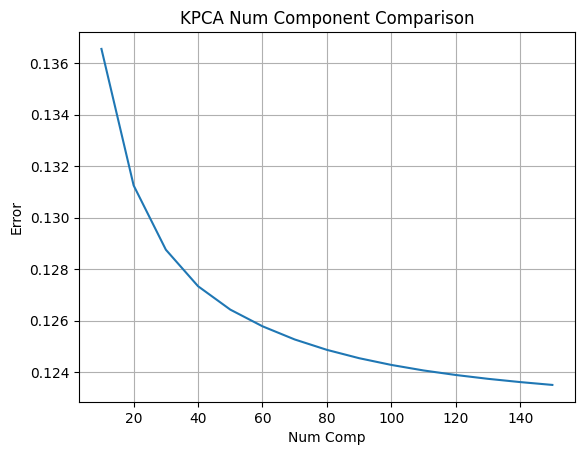

In [8]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
X_train_reduced_sets = []
X_train_reconstructed_sets = []
errors = []
flat_X_train = X_train.reshape(len(X_train), -1)
for component in components:
  kpca = KernelPCA(n_components=component, fit_inverse_transform=True) # keep top k components that explain 95% fo the variance
  X_train_reduced = kpca.fit_transform(flat_X_train) # data transformed via kpca
  X_train_reduced_sets.append(X_train_reduced)
  X_train_reconstructed = kpca.inverse_transform(X_train_reduced) # data attempted to be reconstructed
  X_train_reconstructed_sets.append(X_train_reconstructed)
  error = ((flat_X_train - X_train_reconstructed)**2).mean() # get the mean squared error
  errors.append(error)

# get the index with the min error
plt.plot(components, errors)
plt.xlabel("Num Comp")
plt.ylabel("Error")
plt.title("KPCA Num Component Comparison")
plt.grid(True)
plt.show()

In [9]:
# choose 100 components because begin to plateau there
X_train_reduced = torch.tensor(X_train_reduced_sets[10])
X_train_reconstructed = torch.tensor(X_train_reconstructed_sets[10])

In [10]:
X_train_reduced.shape

torch.Size([1800, 110])

(1800, 28, 20, 1)


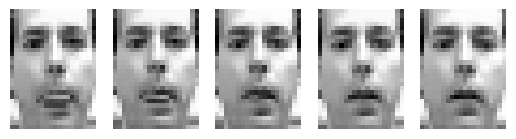

In [11]:
print(X_train.shape)
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
plt.show()

In [12]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [13]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x # custom activation function define by google

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )


    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)

        return output.reshape(*sz)

In [14]:
X_train_reduced.shape

torch.Size([1800, 110])

In [108]:
# training arguments
lr = 0.001
batch_size = 32
iterations = 20000 # 20001
print_every = 1000
hidden_dim = 512
noise_level = 0.1

In [115]:
X = X_train_reduced
# X = X_train
# X = torch.flatten(torch.tensor(X_train), start_dim = 1)

In [116]:
# velocity field model init
vf = MLP(input_dim=X.shape[1], time_dim=1, hidden_dim=hidden_dim).to(device)

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr)

# train
start_time = time.time()
for i in range(iterations):
    optim.zero_grad()

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    idx = torch.randperm(X.size(0))[:batch_size]
    x_1 = X[idx].float()
    # print(f"x_1.shape {x_1.shape}")
    x_0 = x_1 + noise_level * torch.randn_like(x_1)

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device)
    # print(f"t.shape {t.shape}")

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    # print(f"path_sample.x_t {path_sample.x_t.shape}")
    # print(f"path_sample.t {path_sample.t.shape}")
    # print(f"path_sample.dx_t {path_sample.dx_t.shape}")
    loss = torch.pow( vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean()

    # optimizer step
    loss.backward() # backward
    optim.step() # update

    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item()))
        start_time = time.time()

| iter   1000 | 13.35 ms/step | loss    0.010 
| iter   2000 | 12.02 ms/step | loss    0.009 
| iter   3000 | 12.08 ms/step | loss    0.009 
| iter   4000 | 12.00 ms/step | loss    0.008 
| iter   5000 | 11.97 ms/step | loss    0.008 
| iter   6000 | 12.12 ms/step | loss    0.008 
| iter   7000 | 12.06 ms/step | loss    0.008 
| iter   8000 | 12.14 ms/step | loss    0.007 
| iter   9000 | 12.67 ms/step | loss    0.007 
| iter  10000 | 12.28 ms/step | loss    0.007 
| iter  11000 | 12.10 ms/step | loss    0.007 
| iter  12000 | 12.09 ms/step | loss    0.007 
| iter  13000 | 12.08 ms/step | loss    0.006 
| iter  14000 | 11.81 ms/step | loss    0.007 
| iter  15000 | 11.92 ms/step | loss    0.006 
| iter  16000 | 12.06 ms/step | loss    0.007 
| iter  17000 | 11.82 ms/step | loss    0.007 
| iter  18000 | 12.17 ms/step | loss    0.006 
| iter  19000 | 12.09 ms/step | loss    0.005 
| iter  20000 | 12.08 ms/step | loss    0.006 


In [117]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [118]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

idx = torch.randperm(X.size(0))[:batch_size]
x_1 = X[idx].float()
x_0 = x_1 + noise_level * torch.randn_like(x_1)
x_init = x_0
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(
    time_grid=T,
    x_init=x_init,
    method='midpoint',
    step_size=step_size,
    return_intermediates=True
)  # sample from the model



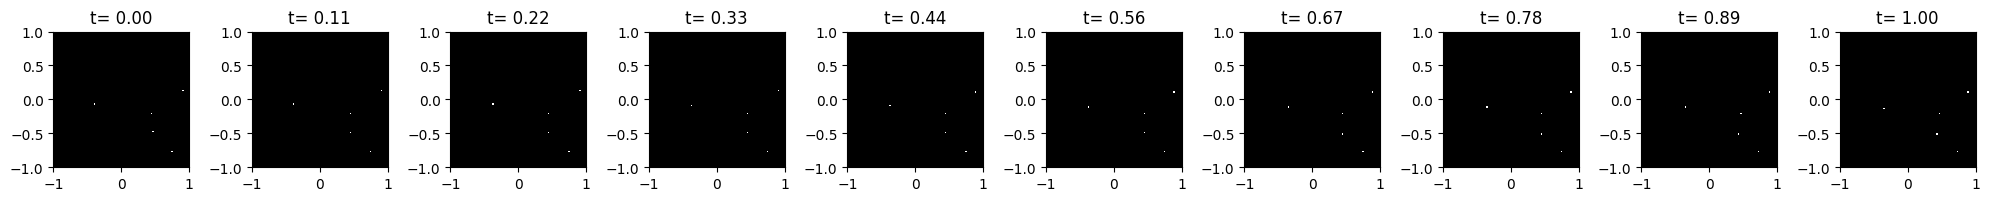

In [119]:
T = T.cpu()

fig, axs = plt.subplots(1, 10,figsize=(20,20))

for i in range(10):
    H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 100, range=((-1, 1), (-1, 1)))

    # cmin = torch.quantile(torch.from_numpy(H[0]), 0.01).item()
    # cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()

    # norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    # _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 100, range=((-5,5), (-5,5)), norm=norm)

    axs[i].set_aspect('equal')
    # axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
plt.show()